In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, RNN
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt


# Example data generation (replace this with your actual dataset)
# X: (19489, 48, 52), y: (19489,)
X = np.load('../data/6hrs/X_6hr.npy')
y = np.load('../data/6hrs/y_6hr.npy')
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [2]:

# Define a custom Time-Gated LSTM cell
class TimeGatedLSTMCell(tf.keras.layers.Layer):
    def __init__(self, units):
        super(TimeGatedLSTMCell, self).__init__()
        self.units = units
        self.state_size = [self.units, self.units]  # [hidden state size, cell state size]
        self.lstm_cell = tf.keras.layers.LSTMCell(units)

    def call(self, inputs, states):
        # Separate the time difference from the rest of the input
        time_diff = inputs[:, -1:]  # Last feature is the time difference
        inputs = inputs[:, :-1]  # Exclude the time difference

        # LSTM cell's forward pass
        output, [h, c] = self.lstm_cell(inputs, states)

        # Time gating mechanism to decay the cell state
        time_gate = K.exp(-K.abs(time_diff))
        c = c * time_gate

        return output, [h, c]

# Define the Time-Gated LSTM Model
def create_time_gated_lstm_model(input_shape, units=64):
    inputs = Input(shape=input_shape)
    lstm_cell = TimeGatedLSTMCell(units)
    # Wrapping LSTM cell with RNN to apply over the sequence
    lstm_out = RNN(lstm_cell)(inputs)
    dense_out = Dense(1, activation='sigmoid')(lstm_out)
    model = Model(inputs, dense_out)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [3]:

# Define input shape and create model
input_shape = (X_train.shape[1], X_train.shape[2])  # (48, 52)
model = create_time_gated_lstm_model(input_shape)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64)


Epoch 1/50


C:\Users\SAIFUL_BADHON\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'time_gated_lstm_cell', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


247/247 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6928 - loss: 0.5852 - val_accuracy: 0.7798 - val_loss: 0.4905
Epoch 2/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7814 - loss: 0.4781 - val_accuracy: 0.7869 - val_loss: 0.4660
Epoch 3/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7905 - loss: 0.4651 - val_accuracy: 0.7922 - val_loss: 0.4598
Epoch 4/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7951 - loss: 0.4585 - val_accuracy: 0.7801 - val_loss: 0.4944
Epoch 5/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7882 - loss: 0.4691 - val_accuracy: 0.8099 - val_loss: 0.4363
Epoch 6/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7995 - loss: 0.4582 - val_accuracy: 0.8013 - val_loss: 0.4452
Epoch 7/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7962 - loss: 0.4572 - val_accuracy: 0.7947 - val_loss: 0.4506
Epoch 8/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7984 - loss: 0.4496 - val_accuracy: 0.7927 

In [12]:

# Predictions
y_pred = model.predict(X_test)
y_pred = (model.predict(X_test) > 0.5).astype(int)
y_pred_proba = model.predict(X_test)

# Evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))


124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.7904328018223234
Precision: 0.7252124645892352
Recall: 0.7886629698089956
F1 Score: 0.755608028335301


In [7]:

np.save('../Scores/validation_loss/TG6-VL.npy', np.array(history.history['val_loss']))
np.save('../Scores/validation_accuracy/TG6-VA.npy', np.array(history.history['val_accuracy']))
np.save('../Scores/training_accuracy/TG6-TA.npy', np.array(history.history['accuracy']))
np.save('../Scores/training_loss/TG6-TL.npy', np.array(history.history['loss']))


np.save('../Scores/ROC-PRC/TG6-y_test.npy', np.array(y_test))
np.save('../Scores/ROC-PRC/TG6-y_pred.npy', np.array(y_pred))
np.save('../Scores/ROC-PRC/TG6-y_pred_proba.npy', np.array(y_pred_proba))


NameError: name 'y_pred' is not defined

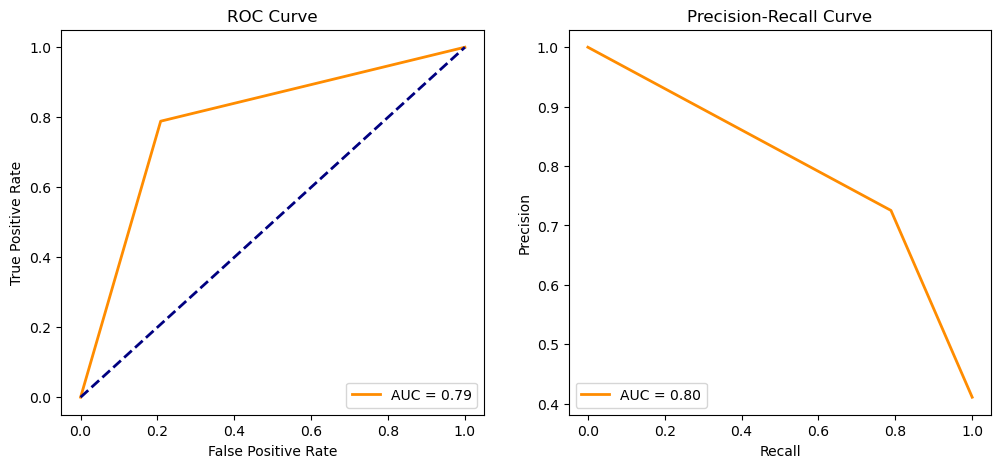

In [17]:

# Plot ROC and Precision-Recall Curves
def plot_roc_pr(y_test, y_pred_proba):
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall, precision)

    # Plotting
    plt.figure(figsize=(12, 5))

    # ROC Plot
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")

    # Precision-Recall Plot
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color="darkorange", lw=2, label=f"AUC = {pr_auc:.2f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend(loc="lower left")

    plt.show()

plot_roc_pr(y_test, y_pred_proba)